"""
An example to demonstrate online linear system identification

We demonstrate the use of OnlineLinearModel class with a simple linear system.
Take a 2D time-varying system dx/dt=A(t)x(t)+B(t)u(t), where A(t) and B(t)
are slowly varying with time. In particular, we take A(t)=(1+eps*t)*A,
B(t)=(1+eps*t)*B, and eps = 0.1 is small. It is discretize with
time step dt = 0.1. Denote the discrete system as x(k)=A(k)x(k-1)+
B(k)u(k-1).

At time step k+1, we need to include new snapshot pair x(k-1), u(k-1), x(k).
We would like to update the adaptive model in real-time

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

In [21]:
!pip install -r requirements.txt

In [22]:
!pip list

Package                            Version             Location
---------------------------------- ------------------- ---------------------------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.0
appscript                          1.1.1
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-

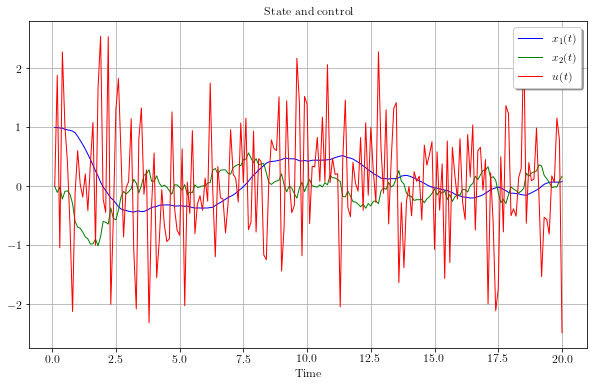

In [24]:
"""
An example to demonstrate online linear system identification

We demonstrate the use of OnlineLinearModel class with a simple linear system.
Take a 2D time-varying system dx/dt=A(t)x(t)+B(t)u(t), where A(t) and B(t)
are slowly varying with time. In particular, we take A(t)=(1+eps*t)*A,
B(t)=(1+eps*t)*B, and eps = 0.1 is small. It is discretize with
time step dt = 0.1. Denote the discrete system as x(k)=A(k)x(k-1)+
B(k)u(k-1).

At time step k+1, we need to include new snapshot pair x(k-1), u(k-1), x(k).
We would like to update the adaptive model in real-time

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""


import matplotlib.pyplot as plt
import numpy as np
from osysid import OnlineLinearModel
from control import lqr, StateSpace


# define dynamics
A = np.array([[0, 1], [-1, -0.1]])
B = np.array([[0], [1]])
epsilon = 0


# time-varying dynamics
def dyn(t, x, u):
    At = (1 + epsilon * t) * A
    Bt = (1 + epsilon * t) * B
    dxdt = At.dot(x) + Bt.dot(u)
    return dxdt


# set up simulation parameter
dt = 0.1
tmax, tc = 20, 0.5
kmax, kc = int(tmax / dt), int(tc / dt)
tspan = np.linspace(0, tmax, kmax + 1)

# dimensions
n = 2
k = 1

# online linear system identification setup
alpha = 0.01 ** (2.0 / kc)
olm = OnlineLinearModel(n, k, None, alpha)

# store data mtrices
x = np.zeros([n, kmax])
u = np.zeros([k, kmax])

# initial condition, state and control
x[:, 0] = np.array([1, 0])
u[:, 0] = np.array([0])

# system simulation
for k in range(1, kmax):
    # forward the system for one step
    x[:, k] = x[:, k - 1] + dt * dyn(k * dt, x[:, k - 1], u[:, k - 1])
    # use new measurement to update online system identification
    olm.update(x[:, k - 1], u[:, k - 1], x[:, k])
    if k > 2 * max(n, n + k):
        # get LQR gain, output = state
        sys = StateSpace(olm.A, olm.B, np.eye(n), np.zeros(n, k), dt=True)
        K, S, E = lqr(sys, np.eye(n), np.eye(k))
        # apply control
        u[:, k] = K.dot(x[:, k])
    else:
        u[:, k] = np.random.randn()


# visualize snapshots
plt.figure(figsize=(10, 6))
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.plot(tspan[1:], x[0, :], "b-", linewidth=1.0, label="$x_1(t)$")
plt.plot(tspan[1:], x[1, :], "g-", linewidth=1.0, label="$x_2(t)$")
plt.plot(tspan[1:], u.reshape(-1), "r-", linewidth=1.0, label="$u(t)$")
plt.legend(loc="best", fontsize=12, shadow=True)
plt.xlabel("Time", fontsize=12)
plt.title("State and control", fontsize=12)
plt.tick_params(labelsize=12)
plt.grid()
plt.show()